<a href="https://colab.research.google.com/github/jaerGitHub/TFM/blob/main/TFMCienciaDatosJAER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aviso: las gráficas de la librería plotly no se visualizan en el preview de Colab que ofrece GitHub. Mejor visualizar el notebook en el propio Google Colab

# 1 PAQUETERÍA

In [17]:
##############################
# MANEJO DE ADVERTENCIAS     #
# Silencia las advertencias  #
##############################
import warnings
warnings.filterwarnings('ignore')

##############################
# MANEJO DE DATOS            #
# Pandas y Numpy             #
##############################
import pandas as pd  # Para manejo de datos
import numpy as np  # Para operaciones numéricas
from numpy import array  # Para crear arreglos Numpy

#####################################
# VISUALIZACIÓN                     #
# Plotly y Matplotlib               #
#####################################
# plotly para visualizaciones interactivas
import plotly.express as px
import plotly.graph_objects as go

# matplotlib para visualizaciones estáticas
from matplotlib import pyplot as plt

#######################################
# ANÁLISIS DE SERIES DE TIEMPO        #
# Statsmodels                         #
#######################################
from statsmodels.tsa.stattools import adfuller  # Para el test de Dickey-Fuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  # Para graficar autocorrelaciones
import statsmodels.api as sm  # API general de Statsmodels

##########################################
# MANEJO DE FECHAS                       #
# Dateutil                               #
##########################################
from dateutil.relativedelta import relativedelta  # Para manipulación de fechas

#####################################
# MACHINE LEARNING Y DEEP LEARNING  #
# Sklearn y TensorFlow              #
#####################################
import tensorflow as tf  # Para crear y entrenar modelos de deep learning
from sklearn.model_selection import train_test_split  # Para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.metrics import mean_squared_error # Para calcular el MSE

# Capas específicas de TensorFlow para construir modelos
from tensorflow.keras.layers import Dropout, MultiHeadAttention, LayerNormalization, Add, Reshape, Normalization, Lambda
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, Identity
from tensorflow.keras.callbacks import EarlyStopping  # Para detener el entrenamiento cuando la métrica deje de mejorar

# 2 BREVE ANÁLISIS DEL CONJUNTO DE DATOS ETTh1

In [18]:
##################################################
# LECTURA DE DATOS Y VISUALIZACIÓN DEL DATAFRAME #
##################################################
path = 'https://raw.githubusercontent.com/jaerGitHub/TFM/main/ETT-small/ETTh1.csv'
df = pd.read_csv(path, sep=',')
print('Done!')
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S") # CASTEO DE LA FECHA
df

Done!


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [19]:
# Verificación de types y descarte de valores nulos
print(df.dtypes)
null_cols = df.isnull().any()
print(null_cols)

date    datetime64[ns]
HUFL           float64
HULL           float64
MUFL           float64
MULL           float64
LUFL           float64
LULL           float64
OT             float64
dtype: object
date    False
HUFL    False
HULL    False
MUFL    False
MULL    False
LUFL    False
LULL    False
OT      False
dtype: bool


In [20]:
#############################################
# REPRESENTACIÓN DEL HISTÓRICO DE LOS DATOS #
#############################################

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df['date']), y=list(df['OT'])))

# Set title
fig.update_layout(
    title_text="Registro horario de los niveles de temperatura del aceite 2016/07/01 00:00:00 a julio de 2018-06-26 19:00:00"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1 mes",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="1 semestre",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1 año",
                     step="year",
                     stepmode="backward"),
                dict(step="all",
                     label="Zoom out")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.update_xaxes(
    dtick="M1",
    #tickformat="%b\n%Y",
    ticklabelmode="period")

fig.show()

In [21]:
#########################
# TEST DE DICKEY-FULLER #
#########################
def adfuller_test(sales):
    result = adfuller(sales, maxlag=int(np.sqrt(df.shape[0])))
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    # Evalúo el p-valor
    if result[1] <= 0.05:
        print("Fuerte evidencia en contra de la hipótesis nula. Se puede rechazar H_0 y asumir que la serie temporal es estacionaria.")
    else:
        print("No hay evidencia en contra de la hipótesis nula. Se asume H_0 como cierta y que la serie temporal no es estacionaria. Toca diferenciar una vez más.")

#########################################
# NECESITAMOS DIFERENCIAR LA SERIE OT ? #
#########################################
adfuller_test(df['OT']) # Aplicamos el test a la variable objetivo

ADF Test Statistic : -2.524563963802982
p-value : 0.10961146068696087
#Lags Used : 131
Number of Observations : 17288
No hay evidencia en contra de la hipótesis nula. Se asume H_0 como cierta y que la serie temporal no es estacionaria. Toca diferenciar una vez más.


In [22]:
df['OT_diff'] = df['OT'].diff()

# Elimina cualquier valor nulo que se haya creado debido a la diferenciación
df = df.dropna()

# Aplica de nuevo la prueba de Dickey-Fuller
adfuller_test(df['OT_diff'])

ADF Test Statistic : -16.277107804072564
p-value : 3.4415564449305597e-29
#Lags Used : 131
Number of Observations : 17287
Fuerte evidencia en contra de la hipótesis nula. Se puede rechazar H_0 y asumir que la serie temporal es estacionaria.


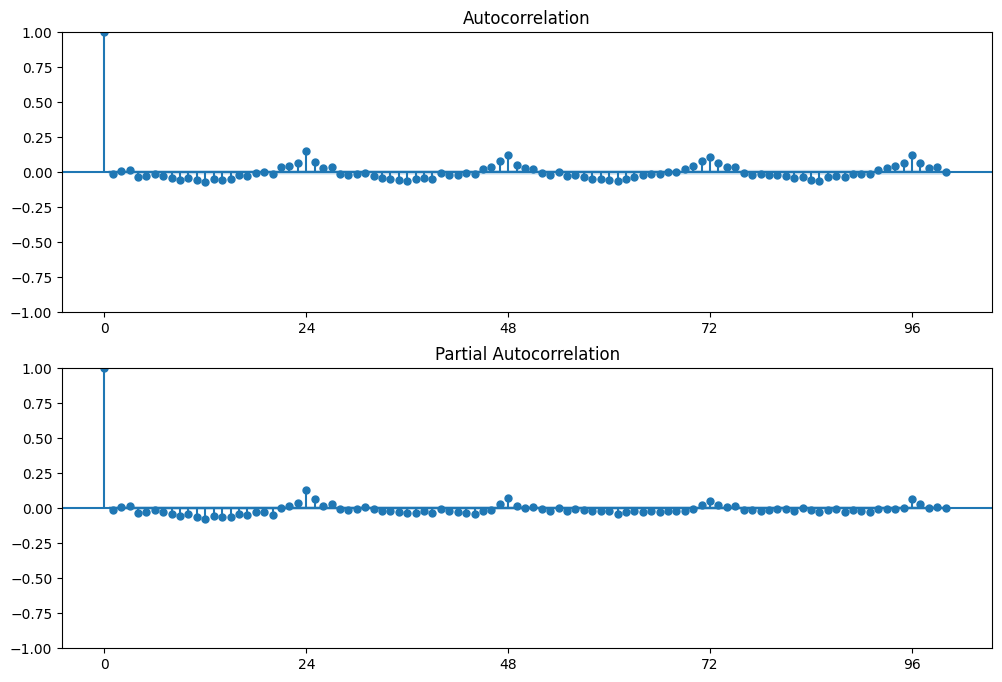

In [23]:
#####################
# ACF Y PACF  DE OT #
#####################

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['OT_diff'],lags=100,ax=ax1)
ax1.xaxis.set_ticks(np.arange(0, 100, 24)) # Establece las marcas de las horas cada 24 horas
ax1.xaxis.set_ticklabels(np.arange(0, 101, 24)) # Establece las etiquetas de las marcas de las horas

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['OT_diff'],lags=100,ax=ax2)
ax2.xaxis.set_ticks(np.arange(0, 100, 24)) # Establece las marcas de las horas cada 24 horas
ax2.xaxis.set_ticklabels(np.arange(0, 101, 24)) # Establece las etiquetas de las marcas de las horas

plt.show()

In [24]:
###########################################
# NECESITAMOS DIFERENCIAR LA SERIE HUFL ? #
###########################################
adfuller_test(df['HUFL'])

ADF Test Statistic : -5.045608690080684
p-value : 1.801448915888918e-05
#Lags Used : 122
Number of Observations : 17296
Fuerte evidencia en contra de la hipótesis nula. Se puede rechazar H_0 y asumir que la serie temporal es estacionaria.


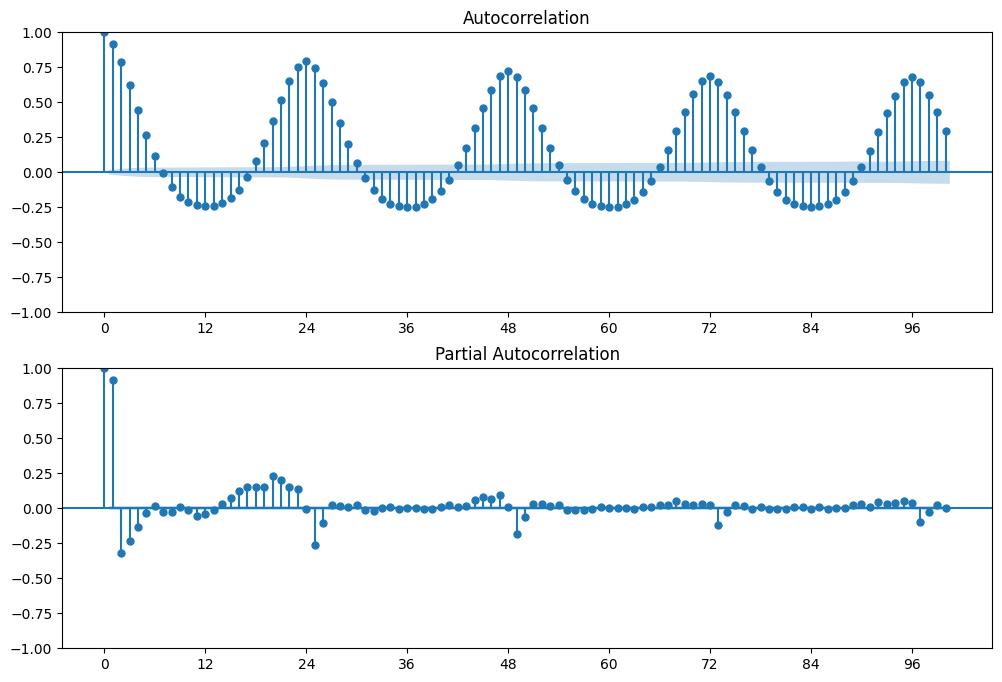

In [25]:
#######################
# ACF Y PACF  DE HUFL #
#######################
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['HUFL'],lags=100,ax=ax1)
ax1.xaxis.set_ticks(np.arange(0, 100, 12)) # Establece las marcas de las horas cada 24 horas
ax1.xaxis.set_ticklabels(np.arange(0, 101, 12)) # Establece las etiquetas de las marcas de las horas

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['HUFL'],lags=100,ax=ax2)
ax2.xaxis.set_ticks(np.arange(0, 100, 12)) # Establece las marcas de las horas cada 24 horas
ax2.xaxis.set_ticklabels(np.arange(0, 101, 12)) # Establece las etiquetas de las marcas de las horas

plt.show()

# 3 DEFINICIÓN DE LAS FECHAS DE TRAIN Y TEST Y PARTICIONAMIENTO

In [26]:
############################################
# LONGITUDES DE VENTANAS PASADAS Y FUTURAS #
############################################

look_back_window_size = 48
look_forward_window_size = 48
# separation = int(NLOOKBACK_DAYS*0.5) # separation

In [27]:
#########################################
###  FECHAS DE ENTRENAMIENTO Y TEST #####
#########################################
TRAIN_START_DATE = pd.to_datetime(df.date.min(), format="%Y-%m-%d")
TEST_END_DATE = pd.to_datetime(df.date.max(), format="%Y-%m-%d")
TRAIN_END_DATE = TEST_END_DATE - relativedelta(days=look_back_window_size/24)
TEST_START_DATE = TRAIN_END_DATE + relativedelta(hours=1)

REGRESSOR_START_DATE = TEST_START_DATE - relativedelta(days=look_back_window_size/24)
REGRESSOR_END_DATE = TEST_START_DATE - relativedelta(hours=1)

In [28]:
print('\n',f'INICIO DE ENTRENAMIENTO: {TRAIN_START_DATE}','\n',
      f'FIN DE ENTRENAMIENTO: {TRAIN_END_DATE}')
print('\n',f'INICIO DE TEST: {TEST_START_DATE}','\n',
      f'FIN DE TEST: {TEST_END_DATE}', '\n',
      f'HORAS DE TEST: {(TEST_END_DATE - TEST_START_DATE).total_seconds() / 3600 + 1} horas')
print('\n',f'INICIO DE VENTANA DE REGRESORES: {REGRESSOR_START_DATE}','\n',
      f'FIN DE VENTANA DE REGRESORES: {REGRESSOR_END_DATE}', '\n',
      f'HORAS DE VENTANA: {(REGRESSOR_END_DATE - REGRESSOR_START_DATE).total_seconds() / 3600 + 1} horas')


 INICIO DE ENTRENAMIENTO: 2016-07-01 01:00:00 
 FIN DE ENTRENAMIENTO: 2018-06-24 19:00:00

 INICIO DE TEST: 2018-06-24 20:00:00 
 FIN DE TEST: 2018-06-26 19:00:00 
 HORAS DE TEST: 48.0 horas

 INICIO DE VENTANA DE REGRESORES: 2018-06-22 20:00:00 
 FIN DE VENTANA DE REGRESORES: 2018-06-24 19:00:00 
 HORAS DE VENTANA: 48.0 horas


In [29]:
df_test = df.query("date >= @REGRESSOR_START_DATE") # REGRESORES Y TEST
df = df.query("date <= @TRAIN_END_DATE") # TRAIN

# 4 PREPROCESAMIENTO DEL CONJUNTO DE ENTRENAMIENTO

In [30]:
#######################################################################
# FUNCIONES PARA LA OBTENCIÓN DE MARCAS DE TIEMPO/TIMESTAMP ENCODINGS #
#######################################################################

def normalize_to_0_1(x, min, max):
    return (x-min)/(max-min)

###################
## FIN DE SEMANA ##
###################

def is_weekend(value_date):
    day = value_date.weekday()
    if day > 4:
        return 1
    else:
        return 0

def get_weekend_column(df_series):
    return list(map(is_weekend, df_series))

######################
## NUMERO DE SEMANA ##
######################
def get_week_number(value_date):
    number_of_week = normalize_to_0_1(value_date.isocalendar()[1],1,53)
    return number_of_week

def get_weeknumber_column(df_series):
    return list(map(get_week_number, df_series))

###################
## DIA DEL MES  ###
###################
def get_day_number_month(value_date):
    number_in_month = normalize_to_0_1(value_date.day,1,31)
    return number_in_month

def get_number_of_month(df_series):
    return list(map(get_day_number_month, df_series))

#######################
## DIA DE LA SEMANA ###
#######################

def day_of_weekend(value_date):
    day_week = normalize_to_0_1(value_date.weekday(), 0, 6)
    return day_week

def get_day_of_week_column(df_series):
    return list(map(day_of_weekend, df_series))

###################
## MES DEL ANYO ###
###################

def number_of_month(value_date):
    day_month = normalize_to_0_1(value_date.month,1,12)
    return day_month

def get_number_of_month_column(df_series):
    return list(map(number_of_month, df_series))


###################
## HORA DEL DIA ###
###################

def hour_of_day(value_date):
    hour_of_day = normalize_to_0_1(value_date.hour,0,23)
    return hour_of_day

def get_hour_of_day_column(df_series):
    return list(map(hour_of_day, df_series))

######################
## SEMANA DEL MES  ###
######################

def week_of_month(value_date):
    # Restar el día del mes por uno y dividir por 7 para obtener la semana del mes
    # Luego, redondeo hacia arriba para obtener un valor de 1 a 5
    week_of_month = normalize_to_0_1((value_date.day - 1) // 7 + 1,1,5)
    return week_of_month

def get_week_of_month_column(df_series):
    return list(map(week_of_month, df_series))

In [31]:
###########################################
## OBTENCIÓN DE LOS TIMESTAMP ENCODINGS ###
###########################################
df['TSE_number_of_month'] = get_number_of_month_column(df['date'])
df['TSE_day_of_week'] = get_day_of_week_column(df['date'])
df['TSE_day_number_month'] = get_number_of_month(df['date'])
df['TSE_number_of_week'] = get_weeknumber_column(df['date'])
df['TSE_hour_of_day'] = get_hour_of_day_column(df['date'])
df['TSE_week_of_month'] = get_week_of_month_column(df['date'])

In [32]:
###########################################################
## FUNCION PARA CONSTRUIR LAS VENTANAS DE ENTRENAMIENTO ###
###########################################################
def split_sequence(sequence, look_back_window_size, dim_output):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + look_back_window_size
        out_end_ix = end_ix + dim_output
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [33]:
#############################################################
## CONSTRUCCION DE LAS VENTANAS DE LA FUNCION OBJETIVO OT ###
#############################################################
OT = df['OT']
OT_LBW, OT_LFW = split_sequence(OT, look_back_window_size, look_forward_window_size)

#####################################################
## CONSTRUCCION DE LAS VENTANAS DE LOS REGRESORES ###
#####################################################
HULL = df['HULL']
HULL_LBW, _ = split_sequence(HULL, look_back_window_size, look_forward_window_size)
MUFL = df['MUFL']
MUFL_LBW, _ = split_sequence(MUFL, look_back_window_size, look_forward_window_size)
MULL = df['MULL']
MULL_LBW, _ = split_sequence(MULL, look_back_window_size, look_forward_window_size)
LUFL = df['LUFL']
LUFL_LBW, _ = split_sequence(LUFL, look_back_window_size, look_forward_window_size)
LULL = df['LULL']
LULL_LBW, _ = split_sequence(LULL, look_back_window_size, look_forward_window_size)

##############################################################
## CONSTRUCCION DE LAS VENTANAS DE LOS TIMESTAMP ENCODINGS ###
##############################################################
TSE_number_of_month = df['TSE_number_of_month']
TSE_number_of_month_LBW, TSE_number_of_month_LFW = split_sequence(TSE_number_of_month, look_back_window_size, look_forward_window_size)
TSE_day_of_week = df['TSE_day_of_week']
TSE_day_of_week_LBW, TSE_day_of_week_LFW = split_sequence(TSE_day_of_week, look_back_window_size, look_forward_window_size)
TSE_day_number_month = df['TSE_day_number_month']
TSE_day_number_month_LBW, TSE_day_number_month_LFW = split_sequence(TSE_day_number_month, look_back_window_size, look_forward_window_size)
TSE_number_of_week = df['TSE_number_of_week']
TSE_number_of_week_LBW, TSE_number_of_week_LFW = split_sequence(TSE_number_of_week, look_back_window_size, look_forward_window_size)
TSE_hour_of_day = df['TSE_hour_of_day']
TSE_hour_of_day_LBW, TSE_hour_of_day_LFW = split_sequence(TSE_hour_of_day, look_back_window_size, look_forward_window_size)
TSE_week_of_month = df['TSE_week_of_month']
TSE_week_of_month_LBW, TSE_week_of_month_LFW = split_sequence(TSE_week_of_month, look_back_window_size, look_forward_window_size)

In [34]:
######################################################################################
## CONCATENACION DE LAS VENTANAS DE LOS TIMESTAMP ENCODINGS DE LA VENTANA A PASADO ###
######################################################################################
TSEs_past_input = np.stack([TSE_number_of_month_LBW, TSE_day_of_week_LBW,
                     TSE_day_number_month_LBW, TSE_number_of_week_LBW,
                     TSE_hour_of_day_LBW, TSE_week_of_month_LBW], axis=-1)

######################################################################################
## CONCATENACION DE LAS VENTANAS DE LOS TIMESTAMP ENCODINGS DE LA VENTANA A FUTURO ###
######################################################################################
TSEs_future_input = np.stack([TSE_number_of_month_LFW, TSE_day_of_week_LFW,
                     TSE_day_number_month_LFW, TSE_number_of_week_LFW,
                     TSE_hour_of_day_LFW, TSE_week_of_month_LFW], axis=-1)

#####################################################
## CONCATENACION DE LAS VENTANAS DE LOS REGRESORES ##
#####################################################
covariates_input = np.stack([HULL_LBW, MUFL_LBW,
                             MULL_LBW, LUFL_LBW,
                             LULL_LBW], axis=-1)

# 5 DEFINICIÓN DE LA ARQUITECTURA 

In [35]:
####################################################################
#### CLASE NORMALIZACIÓN DE VENTANA A LO LARGO DEL EJE TEMPORAL ####
####################################################################
class TemporalNormalization(tf.keras.layers.Layer):
    def call(self, inputs):
        self.mean, self.variance = tf.nn.moments(inputs, axes=-2, keepdims=True)
        self.stddev = tf.sqrt(self.variance)
        normalized_inputs = (inputs - self.mean) / (self.stddev + 1e-6)
        return normalized_inputs, self.mean, self.stddev

###################################################################
### CLASE DENORMALIZACIÓN DE VENTANA A LO LARGO DEL EJE TEMPORAL ##
###################################################################
class TemporalDenormalization(tf.keras.layers.Layer):
    def call(self, inputs, mean, stddev):
        return inputs * (stddev + 1e-6) + mean

#########################################################################
### CLASE MEDIA MOVIL PARA LA OBTENCION DE LA TENDENCIA DE LA VENTANA ###
#########################################################################
class MovingAverage(tf.keras.layers.Layer):
    def __init__(self, window_size, stride, **kwargs):
        super(MovingAverage, self).__init__(**kwargs)
        self.window_size = window_size
        self.stride = stride

    def build(self, input_shape):
        self.avg_pool = tf.keras.layers.AveragePooling1D(pool_size=self.window_size, strides=self.stride, padding='same')

    def call(self, inputs):
        return self.avg_pool(inputs)

###########################
##### MODELO GENERAL ######
###########################
def Transformer(L=look_back_window_size, C=1, CTSEs=TSEs_past_input.shape[2], T=look_forward_window_size):

    #############################
    ##### DEFINICIÓN INPUTS #####
    #############################
    context_input = Input(shape=(L, 1), name='CONTEXT_INPUT') # ventana de historico
    covariates_input = Input(shape=(L, C), name='COVARIATES_INPUT')

    temporal_normalization_1 = TemporalNormalization()
    context_input_norm, mean, stddev = temporal_normalization_1(context_input) # normalizacion de la ventana de historico

    temporal_normalization_2 = TemporalNormalization()
    covariates_input_norm, mean_cov, stddev_cov = temporal_normalization_2(covariates_input) # normalizacion de los regresores

    TSEs_past_input = Input(shape=(L, CTSEs), name='TSEs_PAST_INPUT')

    ############################################################
    ##### OBTENCION DE COMPONENTES TENDENCIAL Y ESTACIONAL #####
    ############################################################
    trend = MovingAverage(window_size=4, stride=1)(context_input_norm)
    remainder = tf.keras.layers.Subtract()([context_input_norm, trend])

    ##################################################################
    # CONCATENACION DE OT + OTTEND + OTSEASONCOMP + REGRESORES + TSE #
    ##################################################################
    concatenated = tf.keras.layers.Concatenate(axis=-1)([context_input_norm, remainder, covariates_input_norm, TSEs_past_input])

    #################################
    # AUMENTO DIMENSIONAL DEL INPUT #
    #################################
    x = Dense(99, kernel_initializer='glorot_uniform')(concatenated)

    concatenated = tf.keras.layers.Concatenate(axis=-1)([context_input_norm, remainder, covariates_input_norm, TSEs_past_input, x])


    ##################################
    ###### ENCODER AUTOATENCION ######
    ##################################
    context_mha_output = MultiHeadAttention(num_heads=4, key_dim=T, dropout=0.1, name='MHA_ENCODER')(concatenated, concatenated)

    x = Add(name='ADD')([context_mha_output, concatenated])
    encoder_output = LayerNormalization(epsilon=1e-6, name='ELN1')(x)

    ##############################
    ###### ATENCION CRUZADA ######
    ##############################

    TSEs_future_input = Input(shape=(T, CTSEs), name='TSEs_FUTURE_INPUT')

    # conocimiento especifico los timestamp encodings futuro
    encoder_output = tf.keras.layers.Concatenate(axis=-1)([encoder_output, TSEs_future_input])

    context_decoder_mha = MultiHeadAttention(num_heads=4, key_dim=T, dropout=0.1, name='MHA_DECODER')(concatenated, encoder_output)

    attention_output = Add()([concatenated, context_decoder_mha])
    attention_output = LayerNormalization(epsilon=1e-6, name='DLN1')(attention_output)

    # DIVISION EN DOS DE LA SALIDA DEL DECODER 
    # decoder_season_output especializada en estacionalidad
    # decoder_trend_output especializada en tendencia
    split = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=-1))(attention_output)
    decoder_season_output, decoder_trend_output = split[0], split[1]
    decoder_season_output = tf.keras.layers.Concatenate(axis=-1)([decoder_season_output, TSEs_future_input])
    decoder_trend_output = tf.keras.layers.Concatenate(axis=-1)([decoder_trend_output, trend])


    sdense_output = Reshape((-1, T))(decoder_season_output)
    tdense_output = Reshape((-1, T))(decoder_trend_output)
    sdense_output = Dense(T, activation=None, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), name='SDENSE_OUTPUT0')(sdense_output)
    tdense_output = Dense(T, activation=None, kernel_initializer='glorot_uniform', name='TDENSE_OUTPUT0')(tdense_output)
    sdense_output = Reshape((T, -1))(sdense_output)
    tdense_output = Reshape((T, -1))(tdense_output)

    sdense_output = Dense(1, activation=None, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), name='SDENSE_OUTPUT1')(sdense_output)
    tdense_output = Dense(1, activation=None, kernel_initializer='glorot_uniform', name='TDENSE_OUTPUT1')(tdense_output)
    sdense_output = Reshape((1, T))(sdense_output)
    tdense_output = Reshape((1, T))(tdense_output)

    sdense_output = Dense(T, activation=None, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), name='SDENSE_OUTPUT2')(sdense_output)
    tdense_output = Dense(T, activation=None, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), name='TDENSE_OUTPUT2')(tdense_output)

    sdense_output = Reshape((T, 1), name='final_reshape1')(sdense_output)
    tdense_output = Reshape((T, 1), name='final_reshape2')(tdense_output)
    st_output = tf.keras.layers.Concatenate(axis=-1)([sdense_output, tdense_output])
    output = Dense(1, activation=None, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), name='FINAL_DENSE')(st_output)

    output = TemporalDenormalization()(output, mean, stddev)

    ###################
    ###### MODEL ###### 
    ###################

    transformer_model = Model(inputs=[context_input, covariates_input, TSEs_past_input, TSEs_future_input],
                              outputs=[output])

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-8) # 5e-5


    loss = tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
    )

    transformer_model.compile(loss='mse', 
                           optimizer=optimizer,
                           metrics=loss)

    transformer_model.summary()

    return transformer_model

In [36]:
#######################################
###### COMPILACION ENTRENAMIENTO ###### 
#######################################
random_seed = 2023
context = OT_LBW.reshape(-1, OT_LBW.shape[1], 1)
target = OT_LFW.reshape(-1, OT_LFW.shape[1], 1)
back_window_train, back_window_val, y_window_train, y_window_val = train_test_split(context, target, test_size=0.15)

TSEs_input_train, TSEs_input_val, TSEs_decoder_input_train, TSEs_decoder_input_val = train_test_split(TSEs_past_input, TSEs_future_input, test_size=0.15, random_state=random_seed)

covariates_input_train, covariates_input_val = train_test_split(covariates_input, test_size=0.15, random_state=random_seed)

training_model = Transformer(L=look_back_window_size, C=covariates_input_train.shape[2], CTSEs=TSEs_input_train.shape[2], T=look_forward_window_size)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CONTEXT_INPUT (InputLayer)     [(None, 48, 1)]      0           []                               
                                                                                                  
 temporal_normalization (Tempor  ((None, 48, 1),     0           ['CONTEXT_INPUT[0][0]']          
 alNormalization)                (None, 1, 1),                                                    
                                 (None, 1, 1))                                                    
                                                                                                  
 moving_average (MovingAverage)  (None, 48, 1)       0           ['temporal_normalization[0][0]'] 
                                                                                              

# 6 ENTRENAMIENTO DEL TRANSFORMER

In [37]:
###########################
###### ENTRENAMIENTO ###### 
###########################
early_stopping = EarlyStopping(patience=5)
training_model.optimizer.learning_rate = 5e-3
history = training_model.fit([back_window_train, covariates_input_train, TSEs_input_train, TSEs_decoder_input_train], [y_window_train],
                                epochs=5,
                                batch_size=32,
                                verbose=1,
                                validation_data=([back_window_val, covariates_input_val, TSEs_input_val, TSEs_decoder_input_val], [y_window_val]))

Epoch 1/5
459/459 [==============================] - 17s 12ms/step - loss: 8.7090 - root_mean_squared_error: 2.9511 - val_loss: 8.3194 - val_root_mean_squared_error: 2.8843
Epoch 2/5
459/459 [==============================] - 5s 10ms/step - loss: 8.3594 - root_mean_squared_error: 2.8913 - val_loss: 8.3291 - val_root_mean_squared_error: 2.8860
Epoch 3/5
459/459 [==============================] - 5s 11ms/step - loss: 8.3423 - root_mean_squared_error: 2.8883 - val_loss: 8.2874 - val_root_mean_squared_error: 2.8788
Epoch 4/5
459/459 [==============================] - 5s 10ms/step - loss: 8.3027 - root_mean_squared_error: 2.8814 - val_loss: 8.3014 - val_root_mean_squared_error: 2.8812
Epoch 5/5
459/459 [==============================] - 5s 11ms/step - loss: 8.3080 - root_mean_squared_error: 2.8824 - val_loss: 8.3158 - val_root_mean_squared_error: 2.8837


# 7 ENTRENAMIENTO SARIMA

In [38]:
!pip install -q pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00


In [39]:
ts = df[['date','OT']]
ts.set_index('date',inplace=True)
ts.index = pd.DatetimeIndex(ts.index.values, freq="H")
mod = sm.tsa.statespace.SARIMAX(ts['OT'], order=(1,1,1), seasonal_order=(1,1,1,24))
fit_res = mod.fit(disp=False)
print(fit_res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 OT   No. Observations:                17371
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -22233.222
Date:                            Wed, 31 May 2023   AIC                          44476.444
Time:                                    06:53:10   BIC                          44515.250
Sample:                                07-01-2016   HQIC                         44489.228
                                     - 06-24-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9519      0.002    445.067      0.000       0.948       0.956
ma.L1         -0.9940      0.001   

# 8 PREPARACIÓN REGRESORES DEL TEST-TRANS

In [40]:
df_test['TSE_number_of_month'] = get_number_of_month_column(df_test['date'])
df_test['TSE_day_of_week'] = get_day_of_week_column(df_test['date'])
df_test['TSE_day_number_month'] = get_number_of_month(df_test['date'])
df_test['TSE_number_of_week'] = get_weeknumber_column(df_test['date'])
df_test['TSE_hour_of_day'] = get_hour_of_day_column(df_test['date'])
df_test['TSE_week_of_month'] = get_week_of_month_column(df_test['date'])

In [41]:
#############################################################
## CONSTRUCCION DE LAS VENTANAS DE LA FUNCION OBJETIVO OT ###
#############################################################
OT = df_test['OT']
OT_LBW_test, OT_LFW_test = split_sequence(OT, look_back_window_size, look_forward_window_size)
OT_LBW_test = OT_LBW_test.reshape(-1, OT_LBW.shape[1], 1)
OT_LFW_test = OT_LFW_test.reshape(-1, OT_LFW.shape[1], 1)

#####################################################
## CONSTRUCCION DE LAS VENTANAS DE LOS REGRESORES ###
#####################################################
HULL = df_test['HULL']
HULL_LBW_test, _ = split_sequence(HULL, look_back_window_size, look_forward_window_size)
MUFL = df_test['MUFL']
MUFL_LBW_test, _ = split_sequence(MUFL, look_back_window_size, look_forward_window_size)
MULL = df_test['MULL']
MULL_LBW_test, _ = split_sequence(MULL, look_back_window_size, look_forward_window_size)
LUFL = df_test['LUFL']
LUFL_LBW_test, _ = split_sequence(LUFL, look_back_window_size, look_forward_window_size)
LULL = df_test['LULL']
LULL_LBW_test, _ = split_sequence(LULL, look_back_window_size, look_forward_window_size)

##############################################################
## CONSTRUCCION DE LAS VENTANAS DE LOS TIMESTAMP ENCODINGS ###
##############################################################
TSE_number_of_month = df_test['TSE_number_of_month']
TSE_number_of_month_LBW_test, TSE_number_of_month_LFW_test = split_sequence(TSE_number_of_month, look_back_window_size, look_forward_window_size)
TSE_day_of_week = df_test['TSE_day_of_week']
TSE_day_of_week_LBW_test, TSE_day_of_week_LFW_test = split_sequence(TSE_day_of_week, look_back_window_size, look_forward_window_size)
TSE_day_number_month = df_test['TSE_day_number_month']
TSE_day_number_month_LBW_test, TSE_day_number_month_LFW_test = split_sequence(TSE_day_number_month, look_back_window_size, look_forward_window_size)
TSE_number_of_week = df_test['TSE_number_of_week']
TSE_number_of_week_LBW_test, TSE_number_of_week_LFW_test = split_sequence(TSE_number_of_week, look_back_window_size, look_forward_window_size)
TSE_hour_of_day = df_test['TSE_hour_of_day']
TSE_hour_of_day_LBW_test, TSE_hour_of_day_LFW_test = split_sequence(TSE_hour_of_day, look_back_window_size, look_forward_window_size)
TSE_week_of_month = df_test['TSE_week_of_month']
TSE_week_of_month_LBW_test, TSE_week_of_month_LFW_test = split_sequence(TSE_week_of_month, look_back_window_size, look_forward_window_size)

In [42]:
######################################################################################
## CONCATENACION DE LAS VENTANAS DE LOS TIMESTAMP ENCODINGS DE LA VENTANA A PASADO ###
######################################################################################
TSEs_past_input_test = np.stack([TSE_number_of_month_LBW_test, TSE_day_of_week_LBW_test,
                     TSE_day_number_month_LBW_test, TSE_number_of_week_LBW_test,
                     TSE_hour_of_day_LBW_test, TSE_week_of_month_LBW_test], axis=-1)

######################################################################################
## CONCATENACION DE LAS VENTANAS DE LOS TIMESTAMP ENCODINGS DE LA VENTANA A FUTURO ###
######################################################################################
TSEs_future_input_test = np.stack([TSE_number_of_month_LFW_test, TSE_day_of_week_LFW_test,
                     TSE_day_number_month_LFW_test, TSE_number_of_week_LFW_test,
                     TSE_hour_of_day_LFW_test, TSE_week_of_month_LFW_test], axis=-1)

#####################################################
## CONCATENACION DE LAS VENTANAS DE LOS REGRESORES ##
#####################################################
covariates_input_test = np.stack([HULL_LBW_test, MUFL_LBW_test,
                             MULL_LBW_test, LUFL_LBW_test,
                             LULL_LBW_test], axis=-1)

# 9 COMPARACION DE AMBOS MODELOS

In [43]:
###########################
### PREDICCIONES SARIMA ###
###########################
# Predicciones para los próximos 48 pasos
forecast = fit_res.get_forecast(steps=look_forward_window_size)

# Obtener el intervalo de confianza para las predicciones
forecast_ci = forecast.conf_int()

# # Imprimir las predicciones
# print(forecast.predicted_mean)

In [44]:
############################
### OBSERVACIONES REALES ###
############################
real_observations = OT_LFW_test.flatten()
real_observations = pd.Series(real_observations, index=forecast.predicted_mean.index)
################################
### PREDICCIONES TRANSFORMER ###
################################
transformer_prediction = training_model.predict([OT_LBW_test, covariates_input_test, TSEs_past_input_test, TSEs_future_input_test]).flatten()
transformer_prediction = pd.Series(transformer_prediction, index=forecast.predicted_mean.index)

1/1 [==============================] - 0s 442ms/step


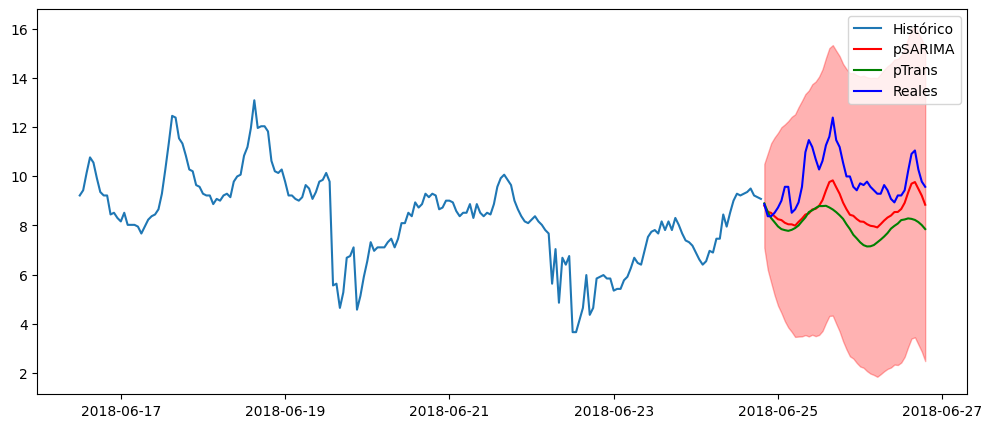

In [45]:
###################################
### REPRESENTACION PREDICCIONES ###
###################################
plt.figure(figsize=(12, 5))
plt.plot(ts.index[-200:], ts['OT'].tail(200), label='Histórico')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='pSARIMA')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='r', alpha=.3)
plt.plot(transformer_prediction.index, transformer_prediction, color='g', label='pTrans')
plt.plot(real_observations.index, real_observations, color='b', label='Reales')
plt.legend()
plt.show()

In [58]:
# Calcula el RMSE
rmse_transformer = np.sqrt(mean_squared_error(real_observations, transformer_prediction))
rmse_forecast = np.sqrt(mean_squared_error(real_observations, forecast.predicted_mean))

# Crea el diagrama de barras
fig = go.Figure()

fig.add_trace(go.Bar(
    x=['Transformer', 'SARIMA'],
    y=[rmse_transformer, rmse_forecast],
    name='RMSE',
    marker_color='midnightblue'
))

fig.update_layout(
    title='Comparación de RMSE SARIMA y Transformer. Test: 8 pm 2018-06-24  7 pm 2018-06-26 19:00:00',
    xaxis=dict(title='Modelo'),
    yaxis=dict(title='RMSE'),
    barmode='group'
)

fig.show()

# X - AUTOSARIMA FRUSTRADO POR RAM

In [46]:
# import pandas as pd
# from pmdarima import auto_arima

# # Convirtiendo la columna 'date' al formato correcto

# ts = df[['date','OT']].copy()
# # Configurando 'date' como índice
# ts.set_index('date', inplace=True)

# # Crear modelo SARIMA
# model = auto_arima(ts['OT'], start_p=1, start_q=1, 
#                    max_p=1, max_q=1, m=24,
#                    start_P=1, start_Q=0,
#                    max_P=1, max_Q=0, D=1,
#                    d=1, seasonal=True, trace=True,
#                    error_action='ignore',  # no queremos errores cuando probamos diferentes combinaciones de parámetros
#                    suppress_warnings=True,  # no queremos convergencia warnings
#                    stepwise=True)  # set to stepwise

# # Imprimir los parámetros del mejor modelo
# print(model.summary())